# Predicting NFL Teams' Next Action

For my model, I decided to explore whether we could reliably predict an NFL team's next action based on the current circumstances they are facing in their game. I did so based on play-by-play data from the 2024 season. While not perfect, the model is significantly better than randomly guessing, and is driven largely by down and distance to the down marker; specifically, the closer a team is to getting a first down, the more likely they are to run, and vice versa. Fourth downs are largely the domain of punting or field goal kicking, depending on distance. I look forward to potentially improving this model by addressing data limitations in subsequent iterations, as well as exploring the applicability of this data set for fantasy football further!
This model is published on GitHub at https://github.com/cgsmith11194/NFL_next_action.

In [2]:
import pandas as pd
import numpy as np

file_path = 'https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_2024.csv' # I would recommend downloading the file and replacing this with local path just to avoid any potential issues

SELECTED_COLUMNS = [
    'home_team',                    # needed for is_home
    'posteam',
    'play_type',
    'air_yards',
    'wind',
    'roof',                         # needed for wind cleaning
    'half_seconds_remaining',
    'game_half',
    'posteam_timeouts_remaining',
    'defteam_timeouts_remaining',
    'down',
    'ydstogo',
    'yardline_100',
    'score_differential',
    'pass_length',
    'home_opening_kickoff',         # needed for 2h receiver
    'two_point_conv_result'         # needed to filter out 2pt attempts
]

df = pd.read_csv(file_path, usecols=SELECTED_COLUMNS)
print(f"Data successfully loaded. Original rows: {len(df)}")

print("--- Cleaning Wind Data ---") #had Gemini help with this section

df['wind_cleaned'] = np.where(df['roof'].str.contains('closed|dome', na=False, regex=True, case=False), 0, df['wind'])

df = df.drop(columns=['wind', 'roof'])
df = df.rename(columns={'wind_cleaned': 'wind'})
df['wind'] = df['wind'].fillna(0) #blank wind values are assumed to be 0

#add is_home column to represent whether possessing team is the home team (since this makes a difference in terms of crowd/home field advantage
df['is_home'] = (df['posteam'] == df['home_team']).astype(int)

#add column for team receiving second half kickoff
df['receiving_2h_kick'] = (df['is_home'] != df['home_opening_kickoff']).astype(int)

#drop records with irrelevant play types, since we don't want info on kickoffs/extra points and penalties could skew analysis
#clock management plays like kneel and spike would also be unpredictable without further modification on the data to determine running clock status - expand on this later
df_before_filter = len(df)
types_to_keep = ['pass', 'punt', 'field_goal', 'run']
two_pt_to_ignore = ['success', 'failure']
df = df[df['play_type'].isin(types_to_keep) & ~df['two_point_conv_result'].isin(two_pt_to_ignore)]
print(f"Dropped {df_before_filter - len(df)} non-competitive play records.")

#convert half to numeric value
df = df[df['game_half'] != 'Overtime'] #ignores overtime plays, of which there are very few and coding would be difficult
df['game_half'] = [int(s[4]) for s in df['game_half']]

'''
commented this code out for now because sacks complicate things - need to give more thought to this and come back eventually

print("--- Detailing Pass Plays ---") #had Gemini help with this
# Define conditions for air_yards (numerical pass depth)
conditions = [(df['air_yards'] >= 15), ((df['air_yards'] > 5) & (df['air_yards'] < 15)), (df['air_yards'] <= 5)]
choices = ['deep_pass', 'med_pass', 'short_pass']

# Use np.select to assign the pass detail
df['pass_detail'] = np.select(conditions, choices, default='')

# Update 'play_type' only for plays where it was originally 'pass'
df['play_type'] = np.where(df['play_type'] == 'pass', df['pass_detail'], df['play_type'])
df = df.drop(columns=['pass_detail', 'air_yards'])
'''


print(f"Final rows for analysis: {len(df)}")
print("\nFirst 5 rows of the cleaned data:")
print(df.head())
print("\nPlay Type Breakdown:")
print(df['play_type'].value_counts(dropna=False))

Data successfully loaded. Original rows: 49492
--- Cleaning Wind Data ---
Dropped 11304 non-competitive play records.
Final rows for analysis: 37997

First 5 rows of the cleaned data:
  home_team posteam  yardline_100  half_seconds_remaining  game_half  down  \
2       BUF     ARI          70.0                  1800.0          1   1.0   
3       BUF     ARI          67.0                  1767.0          1   2.0   
4       BUF     ARI          45.0                  1723.0          1   1.0   
5       BUF     ARI          36.0                  1682.0          1   2.0   
6       BUF     ARI          34.0                  1646.0          1   1.0   

   ydstogo play_type pass_length  air_yards two_point_conv_result  \
2       10       run         NaN        NaN                   NaN   
3        7      pass       short       -3.0                   NaN   
4       10      pass       short        2.0                   NaN   
5        1       run         NaN        NaN                   NaN   
6 

/var/folders/_q/vxkksv_j12vg4yjnxm3g9ywc0000gn/T/ipykernel_1213/3769253718.py:11: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  down_distance_matrix = passrunonly.pivot_table(
/var/folders/_q/vxkksv_j12vg4yjnxm3g9ywc0000gn/T/ipykernel_1213/3769253718.py:11: FutureWarning: The provided callable <function mean at 0x1049a5120> is currently using DataFrameGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  down_distance_matrix = passrunonly.pivot_table(


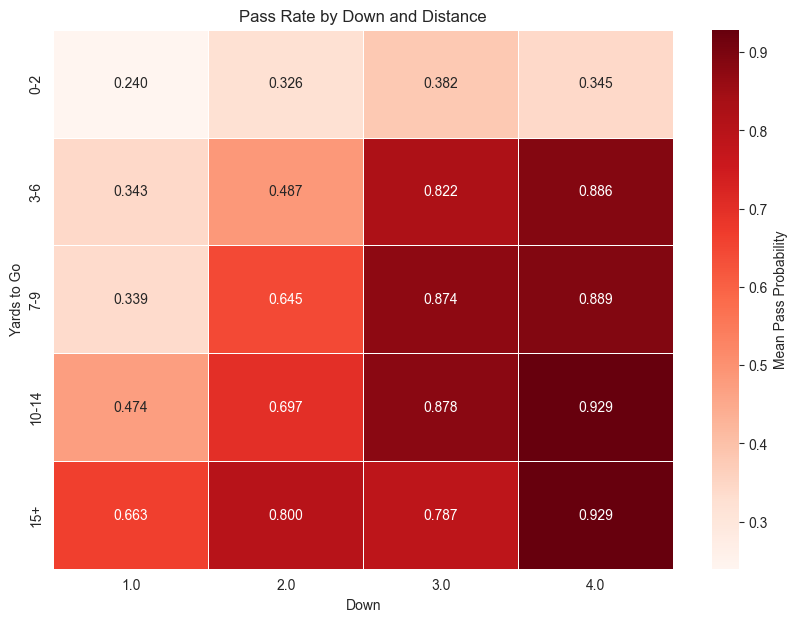

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

pass_run_plays = ['pass', 'run']
passrunonly = df[df['play_type'].isin(pass_run_plays)].copy()

passrunonly['is_pass'] = (passrunonly['play_type'] == 'pass').astype(int)

#got code for visualization from gemini
passrunonly['ydstogo_bin'] = pd.cut(passrunonly['ydstogo'], bins=[0, 3, 7, 10, 15, 99], labels=['0-2', '3-6', '7-9', '10-14', '15+'], right=False)

down_distance_matrix = passrunonly.pivot_table(
    values='is_pass',
    index='ydstogo_bin',
    columns='down',
    aggfunc=np.mean
)

plt.figure(figsize=(10, 7))
sns.heatmap(
    down_distance_matrix,
    annot=True,
    fmt=".3f",
    cmap="Reds",  # Use a sequential colormap (e.g., Reds)
    linewidths=.5,
    linecolor='white',
    cbar_kws={'label': 'Mean Pass Probability'}
)
plt.title('Pass Rate by Down and Distance')
plt.xlabel('Down')
plt.ylabel('Yards to Go')
plt.show()



In [34]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, train_test_split


X = df[['yardline_100', 'half_seconds_remaining', 'game_half', 'down', 'ydstogo', 'posteam_timeouts_remaining', 'defteam_timeouts_remaining', 'score_differential', 'wind', 'is_home', 'receiving_2h_kick']]
y = df['play_type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
model = GradientBoostingClassifier(random_state=1234)
model.fit(X_train, y_train)
param_grid = { #asked Gemini for some support with what might be a good starting point for these parameters
        'n_estimators': [50, 100, 300, 500],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [4, 6, 8, 10],
        'subsample': [0.6, 0.8, 0.9]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.score(X_test, y_test))

{'learning_rate': 0.05, 'max_depth': 6, 'n_estimators': 100, 'subsample': 0.8}
0.7113157894736842


In [36]:
results = pd.DataFrame(grid_search.cv_results_)
output_cols = ['mean_test_score', 'params']
output_df = results[output_cols]
#got this code for sorting results from Gemini
output_df = output_df.sort_values(by='mean_test_score', ascending=False)
print(output_df.reset_index(drop=True))

     mean_test_score                                             params
0           0.712636  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...
1           0.711287  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...
2           0.710827  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...
3           0.710728  {'learning_rate': 0.05, 'max_depth': 6, 'n_est...
4           0.710629  {'learning_rate': 0.05, 'max_depth': 8, 'n_est...
..               ...                                                ...
139         0.672270  {'learning_rate': 0.2, 'max_depth': 10, 'n_est...
140         0.670559  {'learning_rate': 0.2, 'max_depth': 10, 'n_est...
141         0.670329  {'learning_rate': 0.2, 'max_depth': 10, 'n_est...
142         0.668322  {'learning_rate': 0.2, 'max_depth': 6, 'n_esti...
143         0.649734  {'learning_rate': 0.2, 'max_depth': 8, 'n_esti...

[144 rows x 2 columns]


In [37]:
from sklearn.metrics import classification_report

y_pred = grid_search.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  field_goal       0.90      0.92      0.91       254
        pass       0.73      0.71      0.72      3955
        punt       0.92      0.96      0.94       435
         run       0.64      0.66      0.65      2956

    accuracy                           0.71      7600
   macro avg       0.80      0.81      0.80      7600
weighted avg       0.71      0.71      0.71      7600



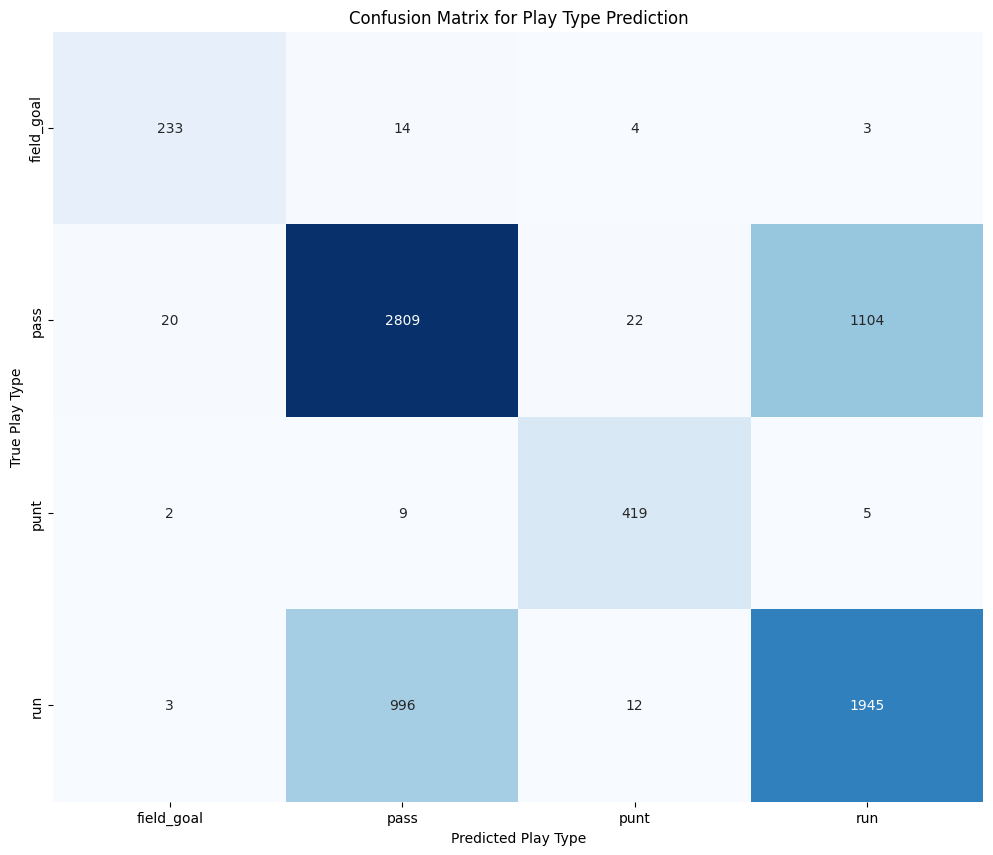

In [40]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_test, y_pred)

#had gemini help with the code for this visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot = True,
    fmt = 'd',
    cmap = 'Blues',
    cbar = False,
    xticklabels = grid_search.best_estimator_.classes_,
    yticklabels = grid_search.best_estimator_.classes_
)
plt.title('Confusion Matrix for Play Type Prediction')
plt.xlabel('Predicted Play Type')
plt.ylabel('True Play Type')
plt.show()

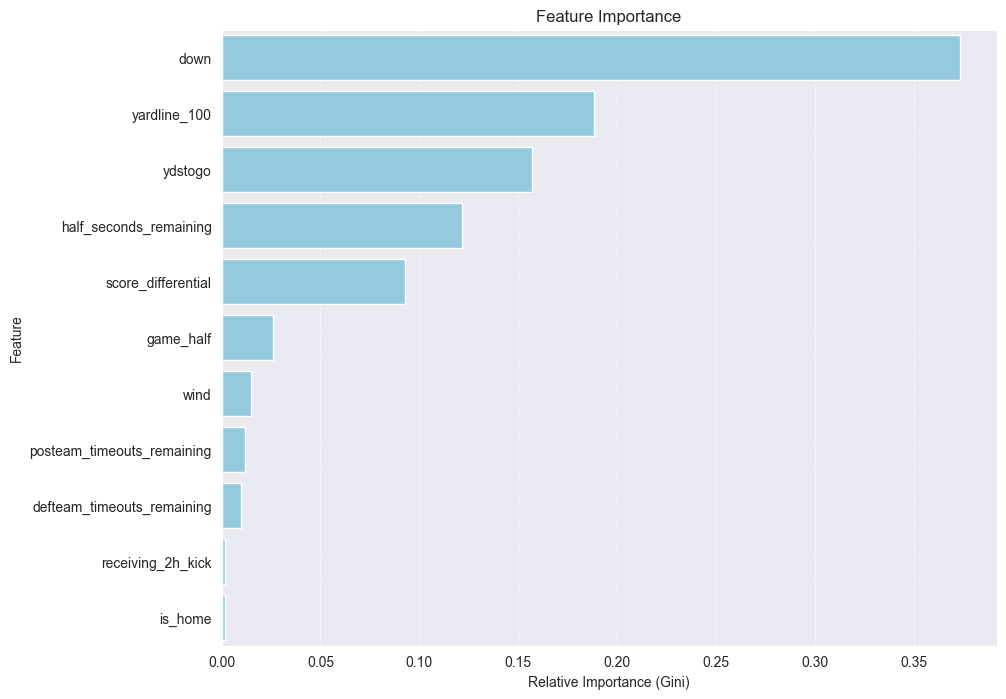

In [11]:
# got help from Gemini here
feature_importances = grid_search.best_estimator_.feature_importances_
feature_cols = X_train.columns

importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(
    x='Importance',
    y='Feature',
    data=importance_df,
    color='skyblue'
)
plt.title('Feature Importance')
plt.xlabel('Relative Importance (Gini)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

/Users/csmith/miniforge3/envs/ds_master/lib/python3.11/site-packages/sklearn/inspection/_partial_dependence.py:717: FutureWarning: The column 4 contains integer data. Partial dependence plots are not supported for integer data: this can lead to implicit rounding with NumPy arrays or even errors with newer pandas versions. Please convert numerical featuresto floating point dtypes ahead of time to avoid problems. This will raise ValueError in scikit-learn 1.9.
  warnings.warn(


<Figure size 1000x600 with 0 Axes>

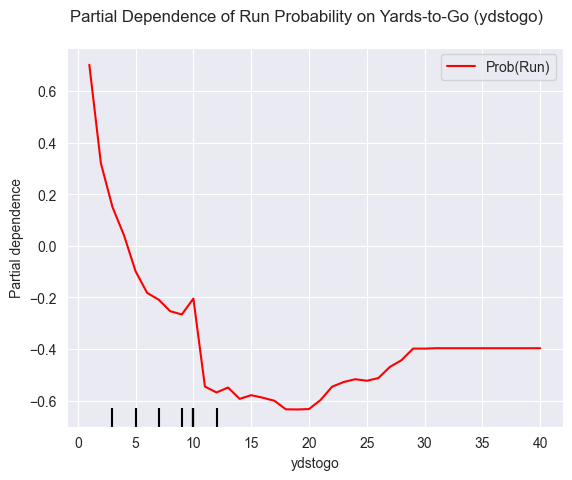

In [17]:
# got help from Gemini here

from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,             # Must use the training data
    features=['ydstogo'],
    target='run', # Target the pass class index
    line_kw={"color": "red", "label": "Prob(Run)"}
)
plt.suptitle('Partial Dependence of Run Probability on Yards-to-Go (ydstogo)')
plt.subplots_adjust(top=0.9)
plt.show()

<Figure size 1000x600 with 0 Axes>

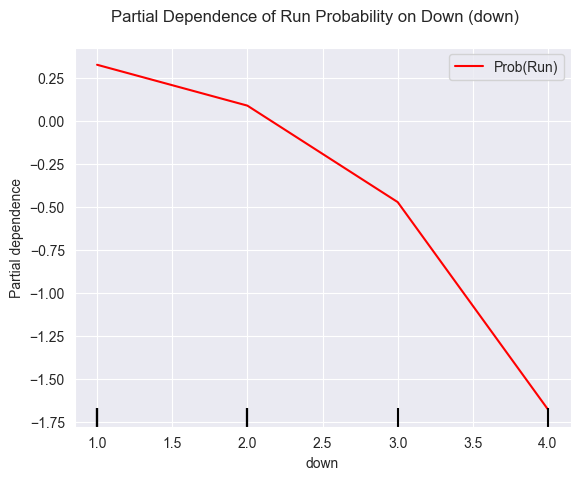

In [18]:
# got help from Gemini here

from sklearn.inspection import PartialDependenceDisplay

plt.figure(figsize=(10, 6))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_train,             # Must use the training data
    features=['down'],
    target='run', # Target the run class index
    line_kw={"color": "red", "label": "Prob(Run)"}
)
plt.suptitle('Partial Dependence of Run Probability on Down (down)')
plt.subplots_adjust(top=0.9)
plt.show()